# Aujourd'hui on roule sur les mecs de l'ENS


https://challengedata.ens.fr/en/challenge/39/prediction_of_transaction_claims_status.html

# Imports des librairies de bases

On ajoutera celles qui manquent au fur et à mesure de nos besoins

In [26]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os, gc

# Définition de la seed pour le random

Très important pour qu'on voit les mêmes choses entre nos deux ordis

In [27]:
RANDOM_SEED = 42;
np.random.seed(RANDOM_SEED)

# Définition des paramètres pour Matplot

Rien de bien intéréssant

In [28]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set des variables globales

Attention, je n'utilise les variables globales pour la gestion des fichiers. Sinon, c'est mort

In [29]:
# Where to save the figures
PROJECT_ROOT_DIR = ".."
DATA_PROCESSED = os.path.join(PROJECT_ROOT_DIR, "data_processed")

# Fonction pour load les libraires

En vrai, on a juste besoin de pd.read_csv, mais c'était pour faire joli

In [30]:
def load_data(file,data_path=DATA_PROCESSED, sep=';'):
    csv_path = os.path.join(data_path, file)
    return pd.read_csv(csv_path, sep=';')

# On load les jeux de données

In [31]:
TX_data = load_data(file = "train.csv");

In [32]:
TX_data.head()

,SHIPPING_MODE,SHIPPING_PRICE,CARD_PAYMENT,COUPON_PAYMENT,RSP_PAYMENT,WALLET_PAYMENT,PRICECLUB_STATUS,REGISTRATION_DATE,PURCHASE_COUNT,BUYER_BIRTHDAY_DATE,...,SELLER_DEPARTMENT_PIB,CAC_POINTS,CAC_VAR,IS_HOLIDAYS,IS_SALES,Mean_Claims_Sells_ID,STD_Claims_Sells_ID,Count_PRODUCT_TYPE,Mean_Claims_PRODUCT_TYPE,STD_Claims_PRODUCT_TYPE
0,NORMAL,0,1,0,1,0,0,2015,0,1992.0,...,20885,5122,5,0,0,0.571429,0.507093,19285.0,0.505522,0.499982
1,NORMAL,0,1,0,0,0,0,2013,0,1952.0,...,20589,5085,0,1,1,0.333333,0.472657,19285.0,0.505522,0.499982
2,NORMAL,0,0,0,0,1,4,2013,3,1991.0,...,-99999,5283,0,0,0,0.607143,0.488575,2583.0,0.573364,0.494684
3,RECOMMANDE,0,1,0,0,0,0,2007,5,1955.0,...,19908,5283,0,0,0,0.707113,0.456042,362.0,0.533149,0.499590
4,RECOMMANDE,0,1,0,1,0,4,2010,1,1984.0,...,-99999,5329,5,0,0,0.628676,0.483239,222.0,0.653153,0.477042


In [33]:
TX_data.drop(['CARD_PAYMENT','COUPON_PAYMENT','RSP_PAYMENT','WALLET_PAYMENT'], axis = 1, inplace = True)

In [34]:
TX_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 30 columns):
SHIPPING_MODE                100000 non-null object
SHIPPING_PRICE               100000 non-null int64
PRICECLUB_STATUS             100000 non-null int64
REGISTRATION_DATE            100000 non-null int64
PURCHASE_COUNT               100000 non-null int64
BUYER_BIRTHDAY_DATE          100000 non-null float64
BUYING_DATE                  100000 non-null int64
SELLER_SCORE_COUNT           100000 non-null int64
SELLER_SCORE_AVERAGE         100000 non-null float64
SELLER_COUNTRY               100000 non-null object
PRODUCT_TYPE                 100000 non-null object
PRODUCT_FAMILY               100000 non-null object
ITEM_PRICE                   100000 non-null int64
CLAIM_TYPE                   100000 non-null object
WARRANTY_COV_RATE            100000 non-null float64
SELLER_COUNTRY_PIB           100000 non-null int64
SELLER_COUNTRY_DISTANCE      100000 non-null int64
BUYER_DEPART

In [35]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(TX_data, 
                                       test_size=0.3, 
                                       random_state=RANDOM_SEED, 
                                       stratify=TX_data["CLAIM_TYPE"]
                                      )
del TX_data;

# Jointure entre les X et Y

In [36]:
def datapreprocess(data):
    data=data.apply(pd.to_numeric, errors='ignore')
    
    # Y and X
    try :
        Y=data["CLAIM_TYPE"]
        X=data.drop("CLAIM_TYPE", axis=1,inplace=False)
    except:
        Y=0
        X=data
    # Exclude Objets
    X=X.select_dtypes(exclude=['object'])
    
    # Work on fare
    from sklearn.preprocessing import Imputer
    imp = Imputer(missing_values='NaN',strategy='median', axis=1)
    X=pd.DataFrame(imp.fit_transform(X),columns=X.columns.values)
 
    return X, Y

In [37]:
X_train, Y_train = datapreprocess(train_set)
X_test, Y_test = datapreprocess(test_set)

#del TX_data;
gc.collect()

4820

In [38]:
def multiclass_roc_auc_score(truth, pred):
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(truth)
    return roc_auc_score(lb.transform(truth), lb.transform(pred), average="weighted")

In [39]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

# MODEL!

In [40]:
from sklearn.model_selection import GridSearchCV

## Gradient Boosting

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
from sklearn.utils.class_weight import compute_sample_weight

In [43]:
sample_weight_arr = compute_sample_weight(class_weight='balanced', y=Y_train)
sample_weight_dict = {'sample_weight':compute_sample_weight(class_weight='balanced', y=Y_train)}

### Gradient Boosting solo

In [53]:
params_GB={
            'criterion':'friedman_mse',
            'init':None,
            'learning_rate':0.25,
            'loss':'deviance',
            'max_depth':3,
            'max_features':'auto',
            'max_leaf_nodes':4,
            'min_impurity_decrease':0.0,
            'min_impurity_split':None,
            'min_samples_leaf':2,
            'min_samples_split':3,
            'min_weight_fraction_leaf':0.0,
            'n_estimators':750,
            'presort':'auto',
            'random_state':RANDOM_SEED,
            'subsample':0.8,
            'verbose':0,
            'warm_start':False
}

In [54]:
gb_clf=GradientBoostingClassifier(**params_GB)

In [55]:
gb_clf.fit(
            X=X_train, 
            y=Y_train, 
            sample_weight=sample_weight_arr
          )

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.25, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=4,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=750,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False)

In [56]:
y_pred_gb_train = gb_clf.predict(X_train)
y_pred_gb = gb_clf.predict(X_test)

In [57]:
train_mAUC = multiclass_roc_auc_score(Y_train, y_pred_gb_train)
test_mAUC = multiclass_roc_auc_score(Y_test, y_pred_gb)

In [58]:
print("Performance sur le train : {}".format(train_mAUC))
print("Performance sur le test : {}".format(test_mAUC))

Performance sur le train : 0.6729532058304196
Performance sur le test : 0.6137334782063697


Score actuel:

Performance sur le train : 0.6963147173736327

Performance sur le test : 0.6102894297640208

Ratio entre les deux : 0.8764563128378458

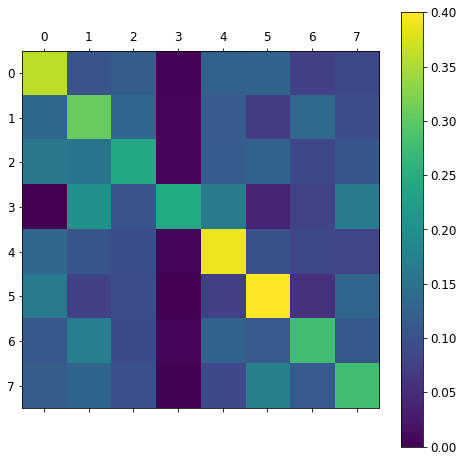

In [59]:
conf_mx = confusion_matrix(Y_test, y_pred_gb)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

### Gradient Boosting Grid Search

In [ ]:
params_GB_CV={
            # Tree-Specific Parameters
            'min_samples_split':list(range(2, 10)),
            'min_samples_leaf':list(range(1,4)),
            'max_depth':list(range(2, 15)),
            
            # Boosting Parameters
            'learning_rate':[0.5, 0.4, 0.3, 0.2, 0.1]
}


params_GB = {
            # Tree-Specific Parameters
    
            #'min_weight_fraction_leaf':0.0,
            #'max_leaf_nodes':None,
            #'min_impurity_decrease':0.0,
            #'min_impurity_split':None,
            'n_estimators':500,
            'max_features':'auto',
    
            # Boosting Parameters
            'subsample':0.8,

            # Miscellaneous Parameters
            'loss':'deviance',
            'init':None,
            'random_state':RANDOM_SEED,
            'criterion':'friedman_mse',
            'verbose':0,
            'warm_start':False,
            'presort':'auto'
}


In [ ]:
gb_gs_cv = GridSearchCV(GradientBoostingClassifier(**params_GB), 
                              params_GB_CV,
                                scoring='f1_weighted',
                              n_jobs=-1,
                              verbose=1)

In [ ]:
gb_gs_cv.fit(X_train, Y_train,groups=None,**sample_weight_dict)

In [ ]:
gb_gs_cv.best_estimator_

In [ ]:
y_pred_cv_gb_train = gb_gs_cv.best_estimator_.predict(X_train)
y_pred_cv_gb = gb_gs_cv.best_estimator_.predict(X_test)

In [ ]:
train_mAUC = multiclass_roc_auc_score(Y_train, y_pred_cv_gb_train)
test_mAUC = multiclass_roc_auc_score(Y_test, y_pred_cv_gb)

In [ ]:
print("Performance sur le train : {}".format(train_mAUC))
print("Performance sur le test : {}".format(test_mAUC))
print("Ratio entre les deux : {} ".format(test_mAUC/train_mAUC))

In [ ]:
conf_mx = confusion_matrix(Y_test, y_pred_cv_gb)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plot_confusion_matrix(norm_conf_mx)

In [ ]:
#RESULTS["CLAIM_TYPE"] = pd.DataFrame(clf.predict(TEST_DATA), columns=["Result"])

In [ ]:
#filename = DATA_PROCESSED+"/submission_2.csv"

#RESULTS.to_csv(filename, index=False, sep=";")